# Fig 2: CA2-silenced mice show increased perseverance in navigating to the old location during the first day and an increased use of non-spatial strategies during the second day of reversal learning.
We quantify search strategies with Rtrack [1]

[1] https://rupertoverall.net/Rtrack/index.html

In [1]:
import numpy as np
from tqdm import tqdm
import expipe
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import copy
from scipy import stats
import tools as tls
from scipy import signal
import plot
import subprocess
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# install Rtrack
rtrack = importr('Rtrack')
rstatix = importr('rstatix')
%load_ext autoreload
%autoreload 2

## Params

In [2]:
path = 'data/expipe'
fname_res = 'data/strategy/df_res.pckl'

dt = 0.1 # dt in s for temporal interpolation
d_pool = 1.2
d_pltfrm = 0.1 # diameter platform in m

t_max = 60 # seconds, maximal time assigned if animal does not reach platform

annulus_outer_rad = d_pltfrm/2*5
annulus_inner_rad = d_pltfrm/2

# replace TeNT/eYFP with CA2-silenced/control
dct_repl = {
    'TeNT': 'CA2-silenced',
    'eYFP': 'control'}

# define colors for each group
palette = sns.color_palette()
ls_palette = [palette[0], palette[1]]

# define whether results shall be recomputed
compute = True

# plotting trials
r_pltfrm = d_pltfrm/2
r_pool = d_pool/2.

fac_scale = 1.1 # scale factor for plotting borders


## Load data

In [3]:
# load project
project = expipe.require_project(path)

# get animals and treatment
ls_animal = []
ls_treatment = []
for key, val in project.entities.items():
    ls_animal.append(int(key))
    ls_treatment.append(val.type)
df_animal = pd.DataFrame({'entities': ls_animal, 'treatment':ls_treatment})

# get trial information
ls_df_info = []
for k, v in project.actions.items():
    if v.type == 'MWM':
        dict_i = {
            **v.attributes,
            **v.modules['test'].contents,
            **v.modules['apparatus'].contents,
            **v.modules['zone'].contents,
            **v.data.contents}
        dict_i['entities'] = int(v.entities[0])
        ls_df_info.append(dict_i)
df_info = pd.DataFrame(ls_df_info)
df_info = pd.merge(df_info, df_animal, on='entities')

# Enable ordering across experimental type, day and trial
ls_df_info_i = []
for i in df_animal['entities']:
    df_info_i = df_info[df_info['entities'] == i]
    df_info_i = df_info_i.sort_values(['fname', 'stage', 'trial'])
    df_info_i['order'] = np.arange(len(df_info_i))
    df_info_i['grp_day_trial'] = df_info_i['fname'] + '_' + df_info_i['stage'] + '_' + df_info_i['trial']
    df_info_i['grp_day'] = df_info_i['fname'] + '_' + df_info_i['stage']
    ls_df_info_i.append(df_info_i)
df_info = pd.concat(ls_df_info_i)

#### Sort df_info
df_info = df_info.reset_index(drop=True)

#### Convert maze info to meter and center
df_info = tls.convert_center_df_info(df_info)

### add adjusted days for plotting
sorted_groups = {
    'MWM_Day1': r'day 3',
    'MWM_Day2': r'day 4',
    'MWM_Day3': r'day 5',
    'MWM_Day4': r'day 6',
    'MWM_Day5': r'day 7',
    'MWM_Probe': r'day 8',
    'MWM-Rev_Day1': r'day 9',
    'MWM-Rev_Day2': r'day 10',
    'MWM-Rev_Day3': r'day 11',
    'MWM-Rev_Day4': r'day 12',
    'MWM-Rev_Day5': r'day 13',
    'MWM-Rev_Probe': r'day 14',}

ls_d = [sorted_groups[d] for d in df_info['grp_day']]
df_info['days_adjusted'] = ls_d

# Get maze information
row_0 = df_info.loc[0]

# check whether info dict is identical for all rows
assert(np.all([row_0['info'] == row_j['info'] for _, row_j in df_info.iterrows()]))

# position of platform
pos_platform = {}
grp = df_info.groupby('fname')
for i, grp_i in grp:
    grp_i_0 = grp_i.iloc[0]
    assert(np.all([
        grp_i_0['Platform'] == grp_i_j['Platform'] for _, grp_i_j in grp_i.iterrows()]))
    xy_pltfrm_i = np.array([
        float(grp_i_0['Platform']['centre']['x']),
        float(grp_i_0['Platform']['centre']['y'])])
    pos_platform[grp_i_0['fname']] = xy_pltfrm_i

# scaling factor pixel to meter
pixelspermetre = float(row_0['pixelspermetre'])

## Classify strategy

In [4]:
if compute:
    ls_res = []

    for i, row_i in tqdm(df_info.iterrows()):

        df_pos_i = pd.read_pickle(row_i['data']['position_data'])

        # get time
        t = np.array(df_pos_i['tm'].astype(float))

        # get coordinates
        x = np.array(df_pos_i['c_x'].astype(float))
        y = np.array(df_pos_i['c_y'].astype(float))
        
        # rescale to m
        x *= 1/pixelspermetre
        y *= 1/pixelspermetre

        xy = np.vstack((x, y)).T

        # center coordinates
        xy_center = np.array([
            row_i['info']['centre']['x'],
            row_i['info']['centre']['y']])
        xy -= xy_center

        # exclude nan values
        xy, t = tls.exclude_nan_values(xy, t)

        # interpolate xy values
        xy, t = tls.interpolate_xy_values(xy, t, dt)

        # get current platform location
        xy_pltfrm = pos_platform[row_i['fname']]

        # get previous platform location in relearning trials
        if row_i['fname'] == 'MWM-Rev' or row_i['grp_day_trial'] == 'MWM_Probe_1':
            xy_pltfrm_old = pos_platform['MWM']
        elif row_i['grp_day_trial'] == 'MWM-Rev_Probe_1':
            xy_pltfrm_old = pos_platform['MWM-Rev']
        else:
            xy_pltfrm_old = None

        # transform arena and path info for rtrack
        # arena
        s_arena = (
            'type = mwm\n'+
            'trial.length = 60\n'+
            'arena.bounds = circle 0.0 0.0 ' + str(d_pool/2.)+'\n'+
            'goal = circle '+str(xy_pltfrm[0]) + ' ' + str(xy_pltfrm[1]) + ' ' + str(d_pltfrm/2.) + '\n')
        if np.any(xy_pltfrm_old):
            s_arena += 'old.goal = circle '+str(xy_pltfrm_old[0]) + ' ' + str(xy_pltfrm_old[1]) + ' ' + str(d_pltfrm/2.)

        # path
        df_tmp = pd.DataFrame({
            'Time': t,
            'X': xy[:, 0],
            'Y': xy[:, 1]})

        # create temporary directory 
        with TemporaryDirectory() as temp_dir:
            #temp_dir = mkdtemp()
            # store and read arena
            fname_arena = temp_dir+'/arena.txt'
            with open(fname_arena, 'w') as f:
                f.write(s_arena)

            # read arena
            arena = rtrack.read_arena(fname_arena)

            # store path
            fname_path = temp_dir+'/path.csv'
            df_tmp.to_csv(
                fname_path,
                sep=',',
                #header=False,
                index=False)


            dct_args = {'track.format': 'raw.csv'}
            # load path
            path = rtrack.read_path(
                fname_path,
                arena,
                **dct_args)

            metrics = rtrack.calculate_metrics(path, arena)

        # define strategy
        strategy = rtrack.call_strategy(metrics)

        # convert to pandas dataframe
        dct_strat = {x: v for x, v in strategy.items()}
        with localconverter(ro.default_converter + pandas2ri.converter):
            df_strat = ro.conversion.rpy2py(dct_strat['calls'])
        assert len(df_strat) == 1

        res = {
            'strategy_idx': int(df_strat['strategy'][0]),
            'strategy_name': df_strat['name'][0],
            'strategy_confidence': df_strat['confidence'][0]}
        # get also confidences for all other strategies
        for i in range(1, 10):
            res[str(i) + '_conf'] = df_strat[str(i)][0]
        ls_res.append(res)

    df_res = pd.DataFrame(ls_res)
    df_res.to_pickle(fname_res)

else:
    df_res = pd.read_pickle(fname_res)
df_info = df_info.join(df_res)

## Plot results 

In [5]:
# define color of each strategy
dct_strat = {
    'thigmotaxis': "#24868EFF",
    'circling': "#365D8DFF",
    'random path': "#365D8DFF",
    'scanning': "#404688FF",
    'chaining': "#5DC863FF",
    'directed search': "#8FD744FF",
    'corrected search': "#C7E020FF",
    'direct path': "#FDE725FF",
    'perseverance': "#440154FF",
}

dct_treat = {
    'TeNT': 'CA2-silenced',
    'eYFP': 'control'}
# Define non-spatial and spatial
strat_group = {
    'non-spatial':[
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'perseverance',
         'direct path',
         'corrected search',
         'directed search',
         'chaining']
}


In [6]:
# Calculate fraction of each strategy per day and treatment
grp_var = 'grp_day_trial'
grp_day_treatment = df_info.groupby([grp_var, 'treatment'])

res = []
for grp_name, grp_dat in grp_day_treatment:
    ls_strat, cnt_strat = np.unique(
        grp_dat['strategy_name'], return_counts=True)
    # calculate fraction of each strategy
    frac_strat = cnt_strat/len(grp_dat)
    res_i = {n:v for n, v in zip(ls_strat, frac_strat)}
    res_i[grp_var] = grp_name[0]
    res_i['treatment'] = grp_name[1]
#    res_i['day'] = grp_dat['grp_day']
    res.append(res_i)
df_res = pd.DataFrame(res)

# resort df_res
grp_day_order = list(df_info[grp_var].unique())
df_res[grp_var] = df_res[grp_var].astype("category")
df_res[grp_var] = df_res[grp_var].cat.set_categories(grp_day_order)
df_res = df_res.sort_values([grp_var])

df_res.columns = pd.CategoricalIndex(
    df_res.columns.values, 
    ordered=True, 
    categories=list(dct_strat.keys())[::-1]+['treatment', 'grp_day_trial'] )

df_res = df_res.sort_index(axis=1)

# add day number to df_res
#days = list(df_info['grp_day'].unique())
ls_idx_days = []
for i, row_i in df_res.iterrows():
    grp_day_trial_i = row_i['grp_day_trial']
    ls_idx_days.append(
       sorted_groups[grp_day_trial_i[:-2]])
 #   ls_idx_days.append(
 #       days.index(grp_day_trial_i[:-2]))
df_res['day'] = ls_idx_days

In [7]:
# calculate width ratios for each subplot
n, c = np.unique(df_res['day'], return_counts=True)
width_ratios = []
for v in sorted_groups.values():
    i = list(n).index(v)
    width_ratios.append(c[i])

width_ratios = np.array(width_ratios)
width_ratios = width_ratios/np.sum(width_ratios)

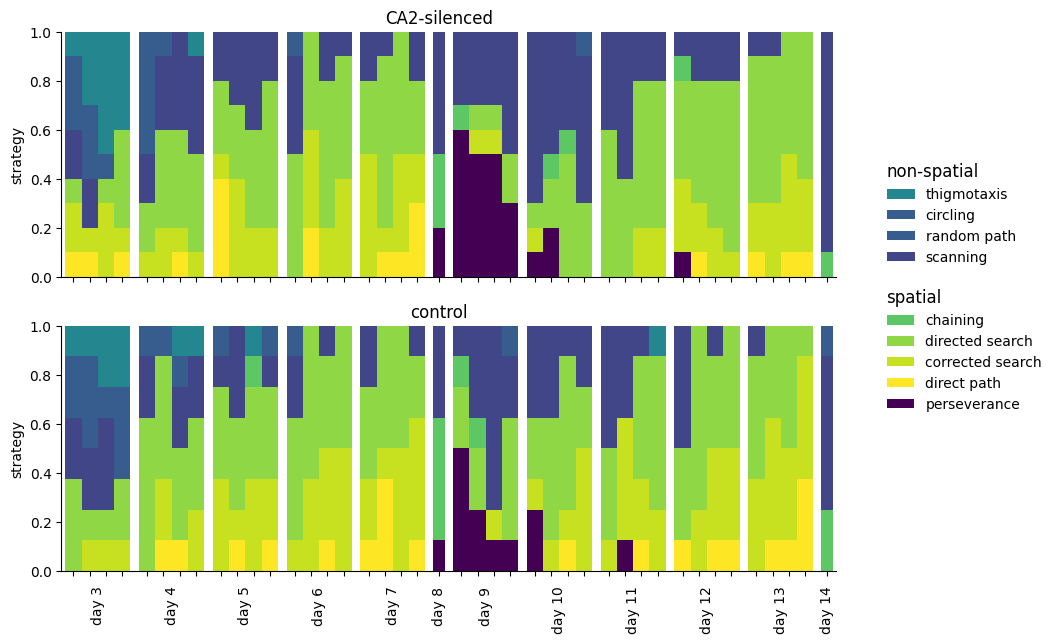

In [8]:
fig, ax = plt.subplots(
    2,
    len(sorted_groups.values()),
    figsize=(10, 7),
    gridspec_kw={
        'width_ratios': width_ratios,
        'wspace': 0.01,
    }
)

ls_pos = [
    [7.29 , 0.],
    [8, 0.6],
]
for i, treat_i in enumerate(['TeNT', 'eYFP']):

    for j, day_j in enumerate(sorted_groups.values()):

        df_ij = df_res[
            (df_res['treatment']==treat_i) &
            (df_res['day']==day_j)
        ]
        plt_ij = df_ij.plot(
            kind='bar',
            x=grp_var,
            stacked=True,
            title=treat_i,
            ylabel='strategy',
            ax=ax[i,j],
            width=1,
            color=list(dct_strat.values())[::-1],
        )
        plt_ij.get_legend().remove()
        ax[i,j].set_ylim(0, 1)

        ax[i,j].spines.right.set_visible(False)
        ax[i,j].spines.top.set_visible(False)
        ax[i,j].set_xticklabels('')    

        if j!=0:
            ax[i,j].spines.left.set_visible(False)
            ax[i,j].set_yticks([])
            ax[i,j].set_ylabel('')          
        
        ax[i,j].set_title('')
        ax[i,j].set_xlabel('')

        if i==1:
            ax[i,j].set_xlabel(df_ij['day'].iloc[0], rotation=90)
        
        if j==5:
            ax[i,j].set_title(dct_treat[treat_i])

 

    handles, labels = ax[i, -1].get_legend_handles_labels()

    for j, (k, v) in enumerate(strat_group.items()):
        
        hndls_lbls_j = np.array(
            [[h, s] for h, s in zip(handles, labels) if s in v],
            dtype=object)
        hndls_j = hndls_lbls_j[:, 0]
        lbls_j = hndls_lbls_j[:, 1]
        
        if i==j:
            leg_i = ax[i, -1].legend(
                reversed(hndls_j),
                reversed(lbls_j),
                title=k,
                alignment='left',
                title_fontsize='large')
            #leg_i._legend_box.align = "left"
            sns.move_legend(
                ax[i, -1],
                "lower center",
                bbox_to_anchor=ls_pos[i],
                frameon=False,    
            )


## Posthoc test - perseverance and spatial strategies

In [9]:
# get ratio of spatial, non-spatial and perseverance
strat_group_pers_extra = {
    'non-spatial':[
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'direct path',
         'corrected search',
         'directed search',
         'chaining'],
    'perseverance': 
        ['perseverance',]
}

def s_in_dct(s, dct):
    # test whether element s is in elements of dct
    # if so, return key
    ls_key = [key for key, val in dct.items() if s in val]
    return ls_key

# per animal and day, calculate fraction of trials for each strategy
df_info['strat_group'] = df_info.apply(
    lambda row: s_in_dct(row['strategy_name'], strat_group_pers_extra)[0], axis=1)

# get number of trials per day
gp_by = ['entities', 'days_adjusted', 'treatment', 'fname', 'stage']
df_n = df_info.groupby(gp_by).size().to_frame(name = 'n_trials').reset_index()

# get number of spatial strategies per day
df_n_spatial = df_info[df_info['strat_group'] == 'spatial'].groupby(
    gp_by).size().to_frame(name = 'n_spatial').reset_index()
df_n_pers = df_info[df_info['strat_group'] == 'perseverance'].groupby(
    gp_by).size().to_frame(name = 'n_perseverance').reset_index()
df_n_nonspatial = df_info[df_info['strat_group'] == 'non-spatial'].groupby(
    gp_by).size().to_frame(name = 'n_nonspatial').reset_index()

# merge both 
df_n = df_n.merge(
    df_n_spatial,
    left_on=gp_by,
    right_on=gp_by,
    how='outer')

df_n = df_n.merge(
    df_n_pers,
    left_on=gp_by,
    right_on=gp_by,
    how='outer')

df_n = df_n.merge(
    df_n_nonspatial,
    left_on=gp_by,
    right_on=gp_by,
    how='outer')

# exchange missing values with 0
df_n = df_n.fillna(0)

# calculate ratio
df_n['ratio_spatial'] = df_n['n_spatial'] / df_n['n_trials']
df_n['ratio_nonspatial'] = df_n['n_nonspatial'] / df_n['n_trials']
df_n['ratio_perseverance'] = df_n['n_perseverance'] / df_n['n_trials']

### Posthoc test perseverance 

In [10]:
for day_sel in list(range(9, 14)):
    df_n_sel = df_n[df_n['days_adjusted']=='day ' + str(day_sel)]
    cnt_pers = []
    for treat_i in ['TeNT', 'eYFP']:
        ratio_i = df_n_sel[df_n_sel['treatment']==treat_i]['ratio_perseverance']
        cnt_pers.append(list(ratio_i))
    res = stats.mannwhitneyu(cnt_pers[0], cnt_pers[1], alternative='greater')
    print('\n --------------\n ')
    print('day ' + str(day_sel))
    print(res)


 --------------
 
day 9
MannwhitneyuResult(statistic=58.0, pvalue=0.05361842520730205)

 --------------
 
day 10
MannwhitneyuResult(statistic=42.0, pvalue=0.43190290746985516)

 --------------
 
day 11
MannwhitneyuResult(statistic=35.0, pvalue=0.8906209977333037)

 --------------
 
day 12
MannwhitneyuResult(statistic=44.0, pvalue=0.2169240328832196)

 --------------
 
day 13
MannwhitneyuResult(statistic=40.0, pvalue=1.0)


In [11]:
for day_sel in list(range(3, 8))+list(range(9, 14)):
    df_n_sel = df_n[df_n['days_adjusted']=='day ' + str(day_sel)]
    cnt_pers = []
    for treat_i in ['TeNT', 'eYFP']:
        ratio_i = df_n_sel[df_n_sel['treatment']==treat_i]['ratio_nonspatial']
        cnt_pers.append(list(ratio_i))
    res = stats.mannwhitneyu(cnt_pers[0], cnt_pers[1], alternative='greater')
    print('\n --------------\n ')
    print(day_sel)
    print(res)


 --------------
 
3
MannwhitneyuResult(statistic=38.0, pvalue=0.5917468146903935)

 --------------
 
4
MannwhitneyuResult(statistic=50.0, pvalue=0.18989051045034988)

 --------------
 
5
MannwhitneyuResult(statistic=41.0, pvalue=0.48113895086378944)

 --------------
 
6
MannwhitneyuResult(statistic=47.0, pvalue=0.2604121080979957)

 --------------
 
7
MannwhitneyuResult(statistic=47.5, pvalue=0.2343582912231036)

 --------------
 
9
MannwhitneyuResult(statistic=36.5, pvalue=0.6470100357592558)

 --------------
 
10
MannwhitneyuResult(statistic=68.0, pvalue=0.004831571544281604)

 --------------
 
11
MannwhitneyuResult(statistic=48.0, pvalue=0.24499766099640424)

 --------------
 
12
MannwhitneyuResult(statistic=37.0, pvalue=0.6389384854053067)

 --------------
 
13
MannwhitneyuResult(statistic=43.0, pvalue=0.3655765200058772)


## Plot fractions 

### Perseverance - day 9

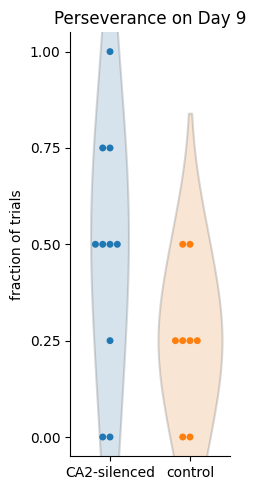

In [12]:
day_sel = 9
df_n_sel = df_n[df_n['days_adjusted']=='day ' + str(day_sel)]
fig, ax1 = plt.subplots(1, figsize=(2.5, 5))
ax1.set_title('Perseverance on Day '+str(day_sel))
#ax1.set_title(strat_i + ' - ' + sorted_groups[day_sel])
swarm_plt = sns.swarmplot(
    data=df_n_sel,
    x='treatment', y='ratio_perseverance',
    ax=ax1,
    palette=ls_palette,
    hue='treatment')  
for pt_i in swarm_plt.collections:
    pt_i.set_alpha(1.)
swarm_plt.get_legend().remove()

violn_plt = sns.violinplot(
    data=df_n_sel,
    x='treatment', y='ratio_perseverance',
    ax=ax1,
    inner=None,
    palette=ls_palette,
    bw=0.9)
ax1.set_ylim(-0.05, 1.05)
ax1.set_ylabel('fraction of trials')
ax1.set_xlabel('')
ax1.set_yticks(df_n['ratio_perseverance'].unique())

for violin in violn_plt.collections[2:]:
    violin.set_alpha(0.2)

ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_xticklabels([dct_repl['TeNT'], dct_repl['eYFP']])

fig.tight_layout()
#fig.savefig('figures/strategy/'+'fraction_nonspatial'+'_day'+str(day_sel)+'.pdf')

### Non-spatial strategies day 10

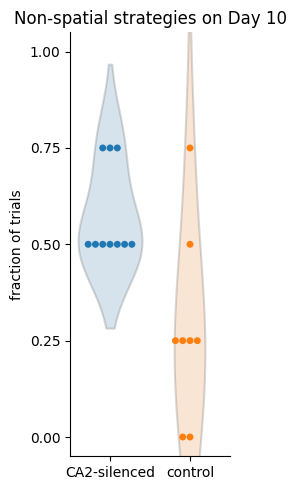

In [13]:
day_sel = 10
df_n_sel = df_n[df_n['days_adjusted']=='day ' + str(day_sel)]
fig, ax1 = plt.subplots(1, figsize=(2.5, 5))
ax1.set_title('Non-spatial strategies on Day '+str(day_sel))
#ax1.set_title(strat_i + ' - ' + sorted_groups[day_sel])
swarm_plt = sns.swarmplot(
    data=df_n_sel,
    x='treatment', y='ratio_nonspatial',
    ax=ax1,
    palette=ls_palette,
    hue='treatment')  
for pt_i in swarm_plt.collections:
    pt_i.set_alpha(1.)
swarm_plt.get_legend().remove()

violn_plt = sns.violinplot(
    data=df_n_sel,
    x='treatment', y='ratio_nonspatial',
    ax=ax1,
    inner=None,
    palette=ls_palette,
    bw=0.9)
ax1.set_ylim(-0.05, 1.05)
ax1.set_ylabel('fraction of trials')
ax1.set_xlabel('')
ax1.set_yticks(df_n['ratio_spatial'].unique())

for violin in violn_plt.collections[2:]:
    violin.set_alpha(0.2)

ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.set_xticklabels([dct_repl['TeNT'], dct_repl['eYFP']])

fig.tight_layout()

## Plot trials

In [14]:
df_sel = df_info[(df_info['entities'].isin([3952, 4031])) & (df_info['grp_day']=='MWM-Rev_Day1')]

0it [00:00, ?it/s]

4031
MWM-Rev_Day1
control


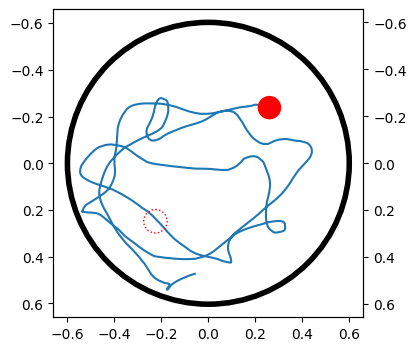

1it [00:00,  8.04it/s]

4031
MWM-Rev_Day1
control


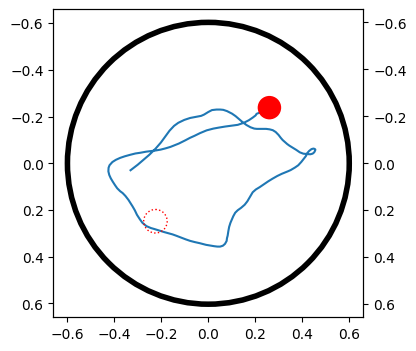

2it [00:00,  8.27it/s]

4031
MWM-Rev_Day1
control


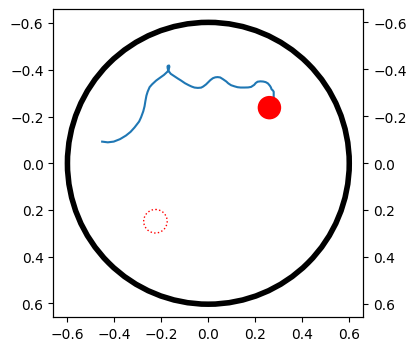

3it [00:00,  8.38it/s]

4031
MWM-Rev_Day1
control


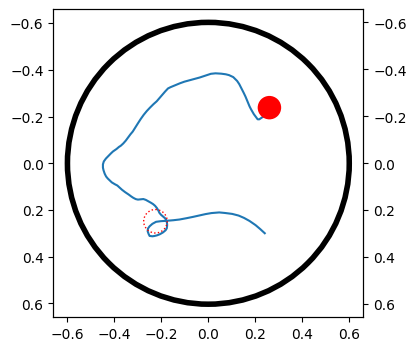

4it [00:00,  8.46it/s]

3952
MWM-Rev_Day1
CA2-silenced


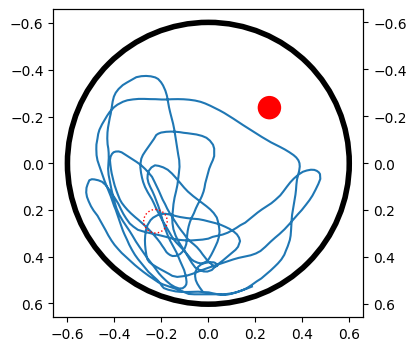

5it [00:00,  8.39it/s]

3952
MWM-Rev_Day1
CA2-silenced


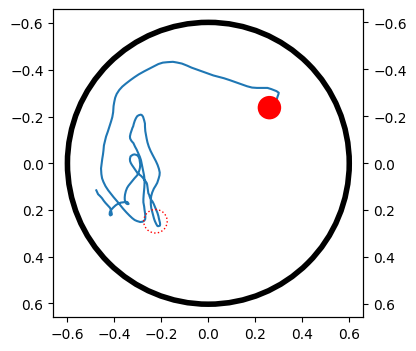

6it [00:00,  8.36it/s]

3952
MWM-Rev_Day1
CA2-silenced


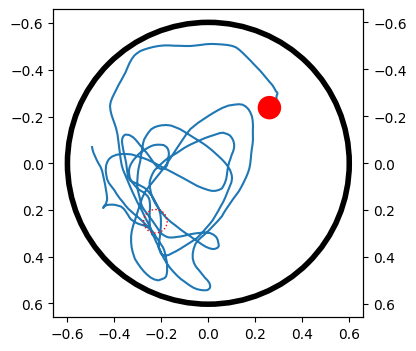

7it [00:00,  8.31it/s]

3952
MWM-Rev_Day1
CA2-silenced


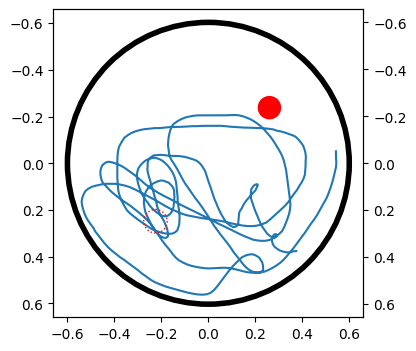

8it [00:00,  8.32it/s]


In [31]:
for i, row_i in tqdm(df_sel.iterrows()):
    print(row_i['entities'])
    print(row_i['grp_day'])
    print(dct_treat[row_i['treatment']])

    df_pos_i = pd.read_pickle(row_i['data']['position_data'])

    # get time
    t = np.array(df_pos_i['tm'].astype(float))
    
    # get coordinates
    x = np.array(df_pos_i['c_x'].astype(float))
    y = np.array(df_pos_i['c_y'].astype(float))
    # flip coordinates of y axis
#    y = -1*y
    
    # rescale to m
    x *= 1/pixelspermetre
    y *= 1/pixelspermetre
    
    xy = np.vstack((x, y)).T

    # center coordinates
    xy_center = np.array([
        row_i['info']['centre']['x'],
        row_i['info']['centre']['y']])
    xy -= xy_center

    # exclude nan values
    xy, t = tls.exclude_nan_values(xy, t)

    # interpolate xy values
    xy, t = tls.interpolate_xy_values(xy, t, dt)
    
    # get current platform location
    xy_pltfrm = pos_platform[row_i['fname']]

    # differentiate between learning, probe learning,
    # reversal learning and probe reversal learning
    kw_pltfrm = None
    xy_pltfrm_old = None
    kw_pltfrm_old = None
    
    if row_i['fname'] == 'MWM' and row_i['stage'] != 'Probe':
        kw_pltfrm = {
            'linewidth': 0,
            'facecolor': 'r',
            'alpha': 0.7
        }
    elif row_i['fname'] == 'MWM' and row_i['stage'] == 'Probe':
        kw_pltfrm = {
            'linewidth': 1,
            'linestyle': 'dotted',
            'edgecolor': 'r',
            'facecolor': (0,0,0,0)
        }
    elif row_i['fname'] == 'MWM-Rev' and row_i['stage'] != 'Probe':
        kw_pltfrm_old = {
            'linewidth': 1,
            'linestyle': 'dotted',
            'edgecolor': 'r',
            'facecolor': (0,0,0,0)
        }
        xy_pltfrm_old = pos_platform['MWM']
    elif row_i['fname'] == 'MWM-Rev' and row_i['stage'] == 'Probe':
        kw_pltfrm_old = {
            'linewidth': 1,
            'linestyle': 'dotted',
            'edgecolor': 'r',
            'facecolor': (0,0,0,0)
        }
        kw_pltfrm = kw_pltfrm_old
        xy_pltfrm_old = pos_platform['MWM']
    
    # define filename
    plot.plot_trajectory(
        xy,
        xy_pltfrm,
        r_pltfrm=r_pltfrm,
        r_pool=r_pool,
        xy_pltfrm_old=xy_pltfrm_old,
        r_pltfrm_old=r_pltfrm,
        kw_pltfrm=kw_pltfrm,
        kw_pltfrm_old=kw_pltfrm_old,
        fname=None,
        display=True,
        flip_y=True
    )